In [1]:
%cd '/content/drive/My Drive/Self Case Study-2'

/content/drive/My Drive/Self Case Study-2


#Libraries

In [2]:
from model import create_model, detect, class_names
from fastai.vision import open_image, ImageBBox, torch, Image, show_image
from skimage import data
from skimage import filters
from skimage import exposure
from skimage import measure
from skimage import segmentation
from skimage import morphology
from skimage import color
import copy
import PIL
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Importing Model

In [3]:
model = create_model()
model.summary()


Pretrained Weight Loaded
Yolo DarkNet weight loaded
Freezed DarkNet layers
Model: "yolov3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 416, 416, 3) 0                                            
__________________________________________________________________________________________________
yolo_darknet (Functional)       ((None, None, None,  40620640    input[0][0]                      
__________________________________________________________________________________________________
yolo_conv_0 (Functional)        (None, 13, 13, 512)  11024384    yolo_darknet[0][2]               
__________________________________________________________________________________________________
yolo_conv_1 (Functional)        (None, 26, 26, 256)  2957312     yolo_conv_0[0][0]                
                 

#Loading Weights

In [4]:
model.load_weights('Weights/Best_weight.hdf5')

# Generating Image Patches
splitting large image into 100 512x512 patches with an overlap of 37 pixels between patches on both axes. Image patches are named following an id_row_column.jpg format

In [5]:
def generate_patches(infile, chopsize = 512, overlap = 37, output_dir = 'data/splited_images/'):
    img = PIL.Image.open(infile)
    width, height = img.size
    step_size = chopsize - overlap

    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    # Save Chops of original image
    for row,y0 in enumerate(range(0, height-chopsize+1, step_size)):
        for col,x0 in enumerate(range(0, width-chopsize+1, step_size)):
            box = (x0, y0, x0+chopsize, y0+chopsize)
            print('%s %s' % (infile, box))
            img.crop(box).save(output_dir+'%s_%d_%d.jpg' % \
                                (infile.split('/')[-1].replace('.jpg',''), row, col))

In [6]:
file = 'data/large_images/16_large.jpg'
path_to_store = 'data/splited_images/'
generate_patches(file, output_dir = path_to_store)

data/large_images/16_large.jpg (0, 0, 512, 512)
data/large_images/16_large.jpg (475, 0, 987, 512)
data/large_images/16_large.jpg (950, 0, 1462, 512)
data/large_images/16_large.jpg (1425, 0, 1937, 512)
data/large_images/16_large.jpg (1900, 0, 2412, 512)
data/large_images/16_large.jpg (2375, 0, 2887, 512)
data/large_images/16_large.jpg (2850, 0, 3362, 512)
data/large_images/16_large.jpg (3325, 0, 3837, 512)
data/large_images/16_large.jpg (3800, 0, 4312, 512)
data/large_images/16_large.jpg (4275, 0, 4787, 512)
data/large_images/16_large.jpg (0, 475, 512, 987)
data/large_images/16_large.jpg (475, 475, 987, 987)
data/large_images/16_large.jpg (950, 475, 1462, 987)
data/large_images/16_large.jpg (1425, 475, 1937, 987)
data/large_images/16_large.jpg (1900, 475, 2412, 987)
data/large_images/16_large.jpg (2375, 475, 2887, 987)
data/large_images/16_large.jpg (2850, 475, 3362, 987)
data/large_images/16_large.jpg (3325, 475, 3837, 987)
data/large_images/16_large.jpg (3800, 475, 4312, 987)
data/lar

#Predicting Bounding Boxes For each Patches

In the csv file we are storing only Floating head tank bounding Boxes int the format of [ymin, xmin, ymax, xmax]

In [7]:
def predict_bboxes(model,dir_path):
    result = []
    for img_f in tqdm(sorted(os.listdir(dir_path)[:])):
        img_path = dir_path+img_f

        img = PIL.Image.open(img_path)
        width, height = img.size
        # print(width, height)

        output = detect(model, img_path, just_prediction=True)
        boxes, scores, classes, nums = output
        Bboxes, Classes = [], []
        for i in range(nums[0]):
            xmin, ymin, xmax, ymax = tuple(np.array(boxes[0][i]))

            xmin = int(round(xmin*width))
            ymin = int(round(ymin*height))
            xmax = int(round(xmax*width))
            ymax = int(round(ymax*height))

            class_name = str(class_names[int(classes[0][i])])
            #Format: ymin, xmin, ymax, xmax
            if(class_name == 'Floating Head Tank'):
                Bboxes.append([ymin, xmin, ymax, xmax]) 
                Classes.append(class_name)

        result.append((img_path, Bboxes, Classes))
    
    result = pd.DataFrame(
        result, 
        columns=['image_name', 'bboxes', 'classes']
    )
    return result

In [8]:
FHTBboxes = predict_bboxes(model,path_to_store)

100%|██████████| 100/100 [02:02<00:00,  1.23s/it]


In [10]:
FHTBboxes[60:70]

image_name  ...                                            classes
60  data/splited_images/16_large_6_0.jpg  ...                                                 []
61  data/splited_images/16_large_6_1.jpg  ...                                                 []
62  data/splited_images/16_large_6_2.jpg  ...                                                 []
63  data/splited_images/16_large_6_3.jpg  ...                                                 []
64  data/splited_images/16_large_6_4.jpg  ...                                                 []
65  data/splited_images/16_large_6_5.jpg  ...                               [Floating Head Tank]
66  data/splited_images/16_large_6_6.jpg  ...           [Floating Head Tank, Floating Head Tank]
67  data/splited_images/16_large_6_7.jpg  ...  [Floating Head Tank, Floating Head Tank, Float...
68  data/splited_images/16_large_6_8.jpg  ...                               [Floating Head Tank]
69  data/splited_images/16_large_6_9.jpg  ...                                                 []

[10 rows x 3 columns]

# Estimating Volumes of Single Tank

##Eliminate Corner Boxes

In [11]:
def check_bb(bbox, shape):
    """
    The algorithm is designed to work with tanks that are fully in frame. 
    Bounding boxes that reach the edge of an image (indicating the tank 
    extends beyond the image) are excluded from processing.
    """
    c, h, w = shape
    ymin, xmin, ymax, xmax = bbox
    if(xmin<=2 or xmin>=w-2):
        return False
    if(xmax<=2 or xmax>=w-2):
        return False
    if(ymin<=2 or ymin>=h-2):
        return False
    if(ymax<=2 or ymax>=h-2):
        return False
    return True

##Intersection of two bounding Boxes

In [12]:
def intersection(bb1, bb2):
    """
    intersection calculates the pixel area intersection between two bounding boxes
    """
    y_min1, x_min1, y_max1, x_max1 = bb1
    y_min2, x_min2, y_max2, x_max2 = bb2
    
    x_left = max(x_min1, x_min2)
    x_right = min(x_max1, x_max2)
    y_top = max(y_min1, y_min2)
    y_bottom = min(y_max1, y_max2)

    intersection = max(0, x_right - x_left + 1) * max(0, y_bottom - y_top+1)
    return intersection

##Crop Single Floated Head Tank

In [13]:
def crop(box, image, factor_x=0.5, factor_y=0.6):
    y_min, x_min, y_max, x_max = (box[0], box[1], box[2], box[3])
    # print(self.gt_coords)
    
    # scale for tank cropping
    margin_x = int((x_max-x_min)*factor_x)
    margin_y = int((y_max-y_min)*factor_y)
    # print(margin_x, margin_y)

    # y_min, y_max, x_min, x_max values for cropping
    c_y_min = max(y_min - margin_y, 0)
    c_y_max = max(y_max + int(margin_y//2), 0)
    c_x_min = max(x_min - margin_x, 0)
    c_x_max = max(x_max + margin_x, 0)
    
    # actual margins, given that the calculated margin might extend beyond the image
    margin_y_true = y_min - c_y_min
    margin_x_true = x_min - c_x_min
    
    # coordinates of the actual bounding box relative to the crop box
    c_bbox_relative = [margin_y_true, margin_x_true, (y_max-y_min)+margin_y_true, (x_max-x_min)+margin_x_true]
    # print(self.bbox_relative)

    # crop section of the image
    c_tank_crop = image.data[:, c_y_min:c_y_max, c_x_min:c_x_max].permute(1,2,0).numpy()
    return c_tank_crop, c_bbox_relative

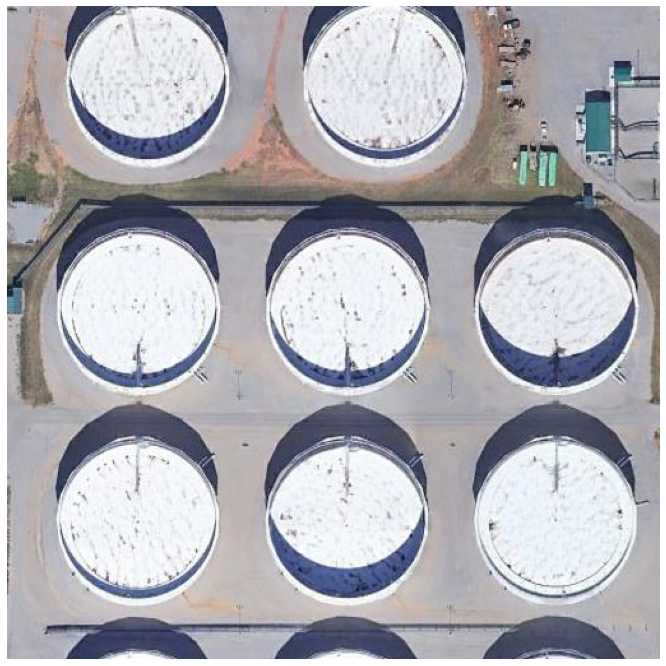

In [15]:
img_path = FHTBboxes['image_name'][67]
boxes = FHTBboxes['bboxes'][67]
im = open_image(img_path)
im.show(figsize=(12,12))

##Croped Folating Head Tank

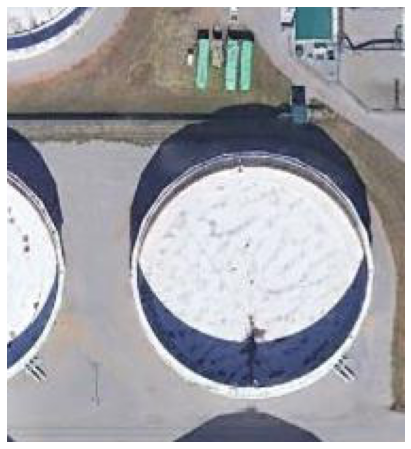

In [16]:
single_tank, bbox_relative=crop(boxes[5], im)
fig, axes = plt.subplots(figsize=(8,8))
axes.imshow(single_tank)
axes.axis('off');

##Enhance Shadow Portion

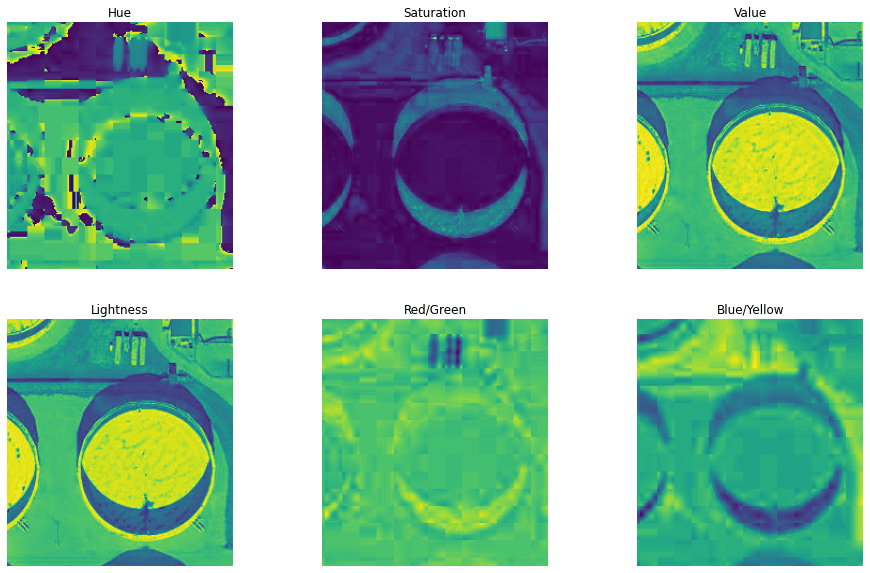

In [17]:
#We first create two versions of the image - one in HSV color space and one in LAB color space
hsv = color.rgb2hsv(single_tank)
H = hsv[:,:,0]
S = hsv[:,:,1]
V = hsv[:,:,2]

lab = color.rgb2lab(single_tank)
l1 = lab[:,:,0]
l2 = lab[:,:,1]
l3 = lab[:,:,2]

#These are the channels from the converted images. Note which channels show a strong contrast between shadow regions and non-shadow regions
fig, axes = plt.subplots(2, 3, figsize=(16,10))

axes[0][0].imshow(H)
axes[0][0].set_title('Hue')

axes[0][1].imshow(S)
axes[0][1].set_title('Saturation')

axes[0][2].imshow(V)
axes[0][2].set_title('Value')

axes[1][0].imshow(l1)
axes[1][0].set_title('Lightness')

axes[1][1].imshow(l2)
axes[1][1].set_title('Red/Green')

axes[1][2].imshow(l3)
axes[1][2].set_title('Blue/Yellow');

for ax in axes.flat:
    ax.axis('off')

Many methods have been proposed for ratioing these channels to enhance shadows. The NSVDI algorithm proposes  S−VS+V . The paper Estimating the Volume of Oil Tanks Based on High-Resolution Remote Sensing which explicitly deals with oil tanks suggests  H+1V+1 .

I found the  H+1V+1  was thrown off by strong artifacts in the H channel, likely due to the source images being RGB jpeg images saved from Google Earth rather than real high resolution satellite photography. The  S−VS+V  method worked well on some images but failed on others.

Experimentally I found the ratio  −(l1+l3)V+1  worked well, where  l1  and  l3  are the first and third channels of the LAB color space image.

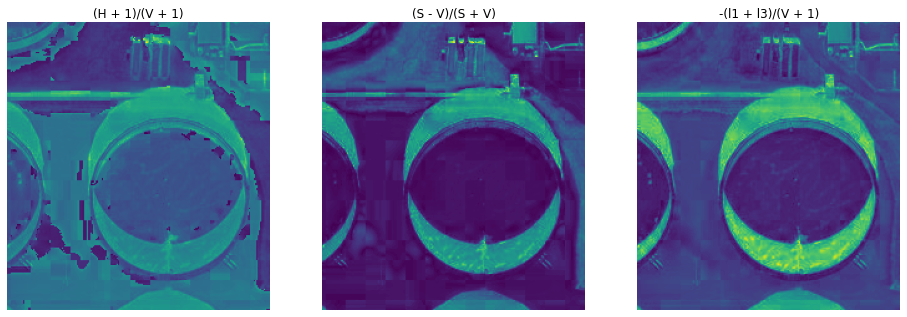

In [19]:
c1 = (H+1)/(V+1)
c2 = (S-V)/(S+V)
c3 = -(l1+l3)/(V+1)

fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes[0].imshow(c1)
axes[0].set_title('(H + 1)/(V + 1)')
axes[1].imshow(c2)
axes[1].set_title('(S - V)/(S + V)')
axes[2].imshow(c3)
axes[2].set_title('-(l1 + l3)/(V + 1)');

for ax in axes.flat:
    ax.axis('off')

## Filter Enhanced Image

The enhanced image is filtered by thresholding. I found the minimum threshold was often too stringent, while the mean threshold was too permissive. a combination of 0.5 * minimum_threshold + 0.4 * mean_threshold works well

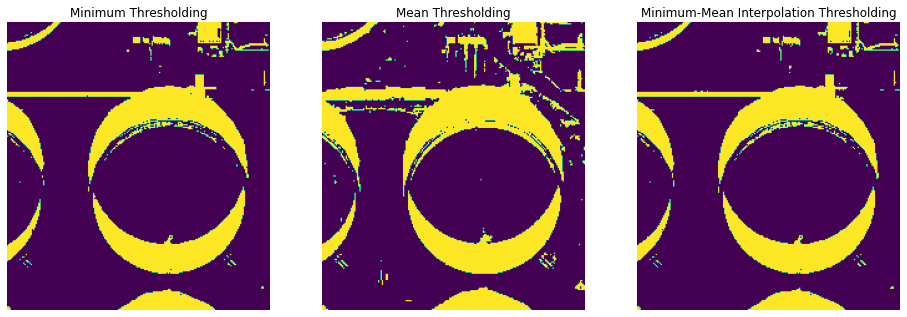

In [28]:
t1 = filters.threshold_minimum(c3)
t2 = filters.threshold_mean(c3)

fig, axes = plt.subplots(1, 3, figsize=(16,6))
axes[0].imshow(c3 > t1)
axes[0].set_title('Minimum Thresholding')
axes[1].imshow(c3 > t2)
axes[1].set_title('Mean Thresholding')
axes[2].imshow(c3 > (0.5*t1 + 0.4*t2))
axes[2].set_title('Minimum-Mean Interpolation Thresholding')

for ax in axes.flat:
    ax.axis('off')

## More Filteration

The thresholded image is then processed with morphological operations. These operations are:

1. Hessian Filter - cleans up noise and line artifacts from white pipes which appear in many images
2. Clear Border - clears contours from surrounding tanks
3. Morphological Closing - helps separate shapes
4. Area Closing - fills small holes
5. Morphological Labeling - labels features

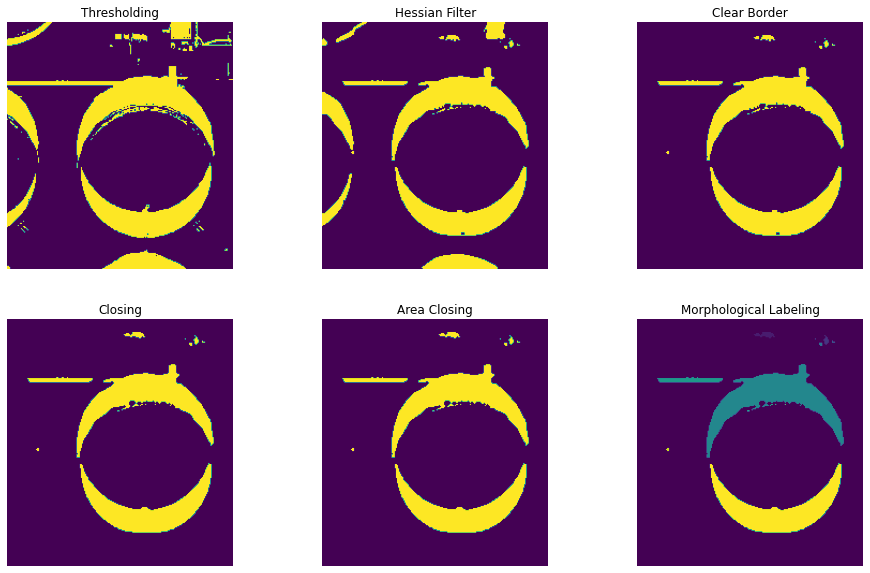

In [29]:
tank_thresh = c3 > (0.5*t1 + 0.4*t2)

label_1 = filters.hessian(tank_thresh)
label_2 = segmentation.clear_border(filters.hessian(tank_thresh))
label_3 = morphology.closing(segmentation.clear_border(filters.hessian(tank_thresh)))
label_4 = morphology.area_closing(morphology.closing(segmentation.clear_border(filters.hessian(tank_thresh))))
label_image = measure.label(morphology.area_closing(morphology.closing(
            segmentation.clear_border(filters.hessian(tank_thresh)))))

fig, axes = plt.subplots(2, 3, figsize=(16,10))

axes[0][0].imshow(tank_thresh)
axes[0][0].set_title('Thresholding')
axes[0][1].imshow(label_1)
axes[0][1].set_title('Hessian Filter')
axes[0][2].imshow(label_2)
axes[0][2].set_title('Clear Border')
axes[1][0].imshow(label_3)
axes[1][0].set_title('Closing')
axes[1][1].imshow(label_4)
axes[1][1].set_title('Area Closing')
axes[1][2].imshow(label_image)
axes[1][2].set_title('Morphological Labeling')

for ax in axes.flat:
    ax.axis('off')

##Extracting Shadow Portion

We then filter the regions present by certain heuristics. The bounding box of the feature should intersect the bounding box of the tank. The feature should have an area of more than 25 pixels. The pixel coverate of the labeled image should be approximately the same as in the threshold image.

The first two clear up small artifacts. The third deals with the fact that the Hessian filter sometimes creates regions in spaces that are otherwise empty.

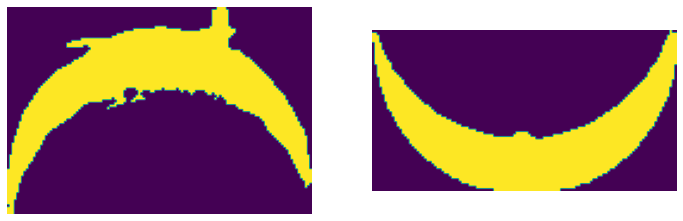

In [30]:
regions_all = measure.regionprops(label_image)
regions = []

for region in regions_all:
    if intersection(bbox_relative, region.bbox) > 300:
        if region.area > 25:
            b = region.bbox
            if abs(tank_thresh[b[0]:b[2], b[1]:b[3]].mean() - region.image.mean()) < 0.06:
                regions.append(region)


fig, axes = plt.subplots(1, 2, figsize=(12, 8))
axes[0].imshow(regions[0].image)
axes[1].imshow(regions[1].image)
for ax in axes.flat:
    ax.axis('off')

##Calculating Volume

Volume is estimated as 1 minus the ratio of the smaller area to the larger area. The larger area corresponds to the exterior shadow of the tank, while the smaller area corresponds to the interior shadow.

In [32]:
areas = np.array([i.area for i in regions])
idx2, idx1 = areas.argsort()[-2:]
print(regions[idx2].area)
print(regions[idx1].area)
volume = 1 - regions[idx2].area / regions[idx1].area
print(volume)

2758
3268
0.15605875152998772


#Estimating Volumes of Large Image 

##Class to Calculate the Volume of Single Tank

In [33]:
class Tank():
    def __init__(self, box, image, factor_x=0.5, factor_y=0.6):

        self.image = image
        self.gt_coords = (box[0], box[1], box[2], box[3]) # bounding box coordinates
        y_min, x_min, y_max, x_max = self.gt_coords
        
        # scale for tank cropping
        margin_x = int((x_max-x_min)*factor_x)
        margin_y = int((y_max-y_min)*factor_y)

        # y_min, y_max, x_min, x_max values for cropping
        self.y_min = max(y_min - margin_y, 0)
        self.y_max = max(y_max + int(margin_y//2), 0)
        self.x_min = max(x_min - margin_x, 0)
        self.x_max = max(x_max + margin_x, 0)
        
        # actual margins, given that the calculated margin might extend beyond the image
        margin_y_true = y_min - self.y_min
        margin_x_true = x_min - self.x_min
        
        # coordinates of the actual bounding box relative to the crop box
        self.bbox_relative = [margin_y_true, margin_x_true, (y_max-y_min)+margin_y_true, (x_max-x_min)+margin_x_true]

        # crop section of the image
        self.tank_crop = self.image.data[:, self.y_min:self.y_max, self.x_min:self.x_max].permute(1,2,0).numpy()
        
        self.proc_tank()
        self.get_regions()

    def proc_tank(self):
        # HSV conversion
        hsv = color.rgb2hsv(self.tank_crop)
        H = hsv[:,:,0]
        S = hsv[:,:,1]
        V = hsv[:,:,2]
        
        # LAB conversion
        lab = color.rgb2lab(self.tank_crop)
        l1 = lab[:,:,0]
        l2 = lab[:,:,1]
        l3 = lab[:,:,2]
        
        # Enhanced image
        self.tank_hsv = -(l1+l3)/(V+1)
        
        # Threshold values
        t1 = filters.threshold_minimum(self.tank_hsv)
        t2 = filters.threshold_mean(self.tank_hsv)
        
        # Thresholding
        self.tank_thresh = self.tank_hsv > (0.5*t1 + 0.4*t2)
        
        # Processed, labeled image
        self.label_image = measure.label(morphology.area_closing(morphology.closing(
            segmentation.clear_border(filters.hessian(self.tank_thresh)))))
        
    def get_regions(self):
        # Regions within image
        self.regions_all = measure.regionprops(self.label_image)
        
        self.regions = []
        
        # Some regions are noise. This ensures that regions have a decent area ( > 25 px),
        # that the region intersects the boudning box around the tank (removes lots of noisy features)
        # and that the processed region is also present in the thresholded image (the hessian filter can sometimes 
        # add artifacts that need to be removed this day)
        for region in self.regions_all:
            if intersection(self.bbox_relative, region.bbox) > 300:
                if region.area > 25:
                    b = region.bbox
                    if abs(self.tank_thresh[b[0]:b[2], b[1]:b[3]].mean() - region.image.mean()) < 0.06:
                        self.regions.append(region)
                            
        # areas of all regions
        areas = np.array([i.area for i in self.regions])
        
        # if there are more than two areas found, take the two largest
        # 1 - ratio of the two largest areas calculates the volume estimation
        if len(areas) > 1:
            idx2, idx1 = areas.argsort()[-2:]
            self.volume = 1 - self.regions[idx2].area / self.regions[idx1].area
        # if only 1 area is found, tank is assumed to be full
        else:
            idx2 = 0
            idx1 = 0
            self.volume = 1
        
        # Blank image onto which to paste only the two shadow regions
        self.blank = np.zeros(self.tank_crop.shape[:2])

        for region in [self.regions[idx1], self.regions[idx2]]:
            y_min, x_min, y_max, x_max = region.bbox
            self.blank[y_min:y_max, x_min:x_max] += region.image.astype('uint8')
                        
        # get contours of shadows
        self.contours = measure.find_contours(self.blank, 0.5)
        if len(self.contours) > 1:
            # If there are multiple contours, take the two longest
            contour_idxs = np.array([len(i) for i in self.contours]).argsort()[-2:]
        else:
            contour_idxs = [0]
        self.contours_select = [self.contours[i] for i in contour_idxs]

##Class to Calculate the Volume of Multiple Tank

In [34]:
class MultiTank():
    def __init__(self, bbs, image):
        self.image = image
        # check bounding boxes aren't at the edge of the image
        self.bbs = [i for i in bbs if check_bb(i, image.shape)]
        self.tanks = []
        for i in self.bbs:
            try:
                self.tanks.append(Tank(i, image))
            except:
                # print('Error')
                pass
        
        self.create_masks()
    def plot_volumes(self, figsize=(12,12), ax=None):
        coords = [i.gt_coords for i in self.tanks]
        classes = list(range(len(self.tanks)))
        labels = ['{:.3f}'.format(i.volume) for i in self.tanks]
        bbox_vol = ImageBBox.create(*self.image.size, coords, classes, classes=labels)
        self.image.show(figsize=figsize, y=bbox_vol, ax=ax)
        
    def plot_contours(self, figsize=(12,12)):
        fig, ax = plt.subplots(figsize=figsize)
        show_image(self.image, ax=ax)
        
        colors = np.linspace(0, 1, len(self.tanks))
        
        for i, tank in enumerate(self.tanks):
            for contour in tank.contours_select:
                ax.plot(contour[:,1]+tank.x_min, contour[:,0]+tank.y_min, color=plt.cm.rainbow(colors[i]))
    def create_masks(self):
        mask = np.zeros(self.image.shape[1:])
        colors = np.linspace(0, 1, len(self.tanks))
        
        for i, tank in enumerate(self.tanks):
            tank_blank = (tank.blank > 0) * (i + 1)
            mask[tank.y_min:tank.y_max, tank.x_min:tank.x_max] += tank_blank
            
        self.mask = mask
        self.mask_binary = mask > 0

## Merging Patches Into Large Image

### Region of Image to merge

In [35]:
def get_idxs(start, rows, cols):
    idxs = []
    for r in range(rows):
        row = []
        for c in range(cols):
            row.append(start + c + 10*r)
        idxs.append(row)
        
    return idxs

###Merge Images and modify bounding Boxes Accordingly

In [36]:
def generate_composite(idxs, patch_size = 512, overlap = 37):
    rows = len(idxs)
    cols = len(idxs[0])
    patch_height, patch_width = (patch_size, patch_size)
    overlap_height, overlap_width = (overlap, overlap)

    image_height = rows*patch_height - overlap_height * (rows-1)
    image_width = cols*patch_width - overlap_width * (cols-1)

    step_width = patch_width - overlap_width
    step_height = patch_height - overlap_height

    im_mask = torch.zeros((3, image_height, image_width))
    bbs = []

    for i, row in enumerate(idxs):
        for k, idx in enumerate(row):
            fname = copy.deepcopy(FHTBboxes['image_name'][idx])
            im = open_image(fname)
            im_mask[:, (i*step_height):(i*step_height)+patch_height, (k*step_width):(k*step_width)+patch_width] = im.data
            try:
                bbox_scaled = copy.deepcopy(FHTBboxes['bboxes'][idx])
                for j in range(len(bbox_scaled)):
                    bbox_scaled[j][0] += step_height * i #ymin
                    bbox_scaled[j][1] += step_width * k  #xmin
                    bbox_scaled[j][2] += step_height * i #ymax
                    bbox_scaled[j][3] += step_width * k  #xmax

                bbox_scaled = [j for j in bbox_scaled if check_bb(j, im_mask.shape)]
                bbox_clean = []
                for box in bbox_scaled:
                    y_min, x_min, y_max, x_max = box[0], box[1], box[2], box[3]
                    if not (x_max-x_min) <=40 or (y_max-y_min) <=40:
                        bbox_clean.append(box)

                bbs += bbox_clean
            except:
                pass
    return (im_mask, bbs)

##Merged Image Along With Floating Head Bounding Boxes

In [37]:
idxs = get_idxs(0, 10, 10)
idxs

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
 [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
 [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
 [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
 [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
 [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
 [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
 [90, 91, 92, 93, 94, 95, 96, 97, 98, 99]]

In [38]:
im_mask, bbs = generate_composite(idxs)

In [39]:
composite_image = Image(im_mask)
box_vol = ImageBBox.create(*composite_image.size, bbs)

composite_image.show(figsize=(16,16), y=box_vol)

Output hidden; open in https://colab.research.google.com to view.

##Volume of Each Floating Head Tank

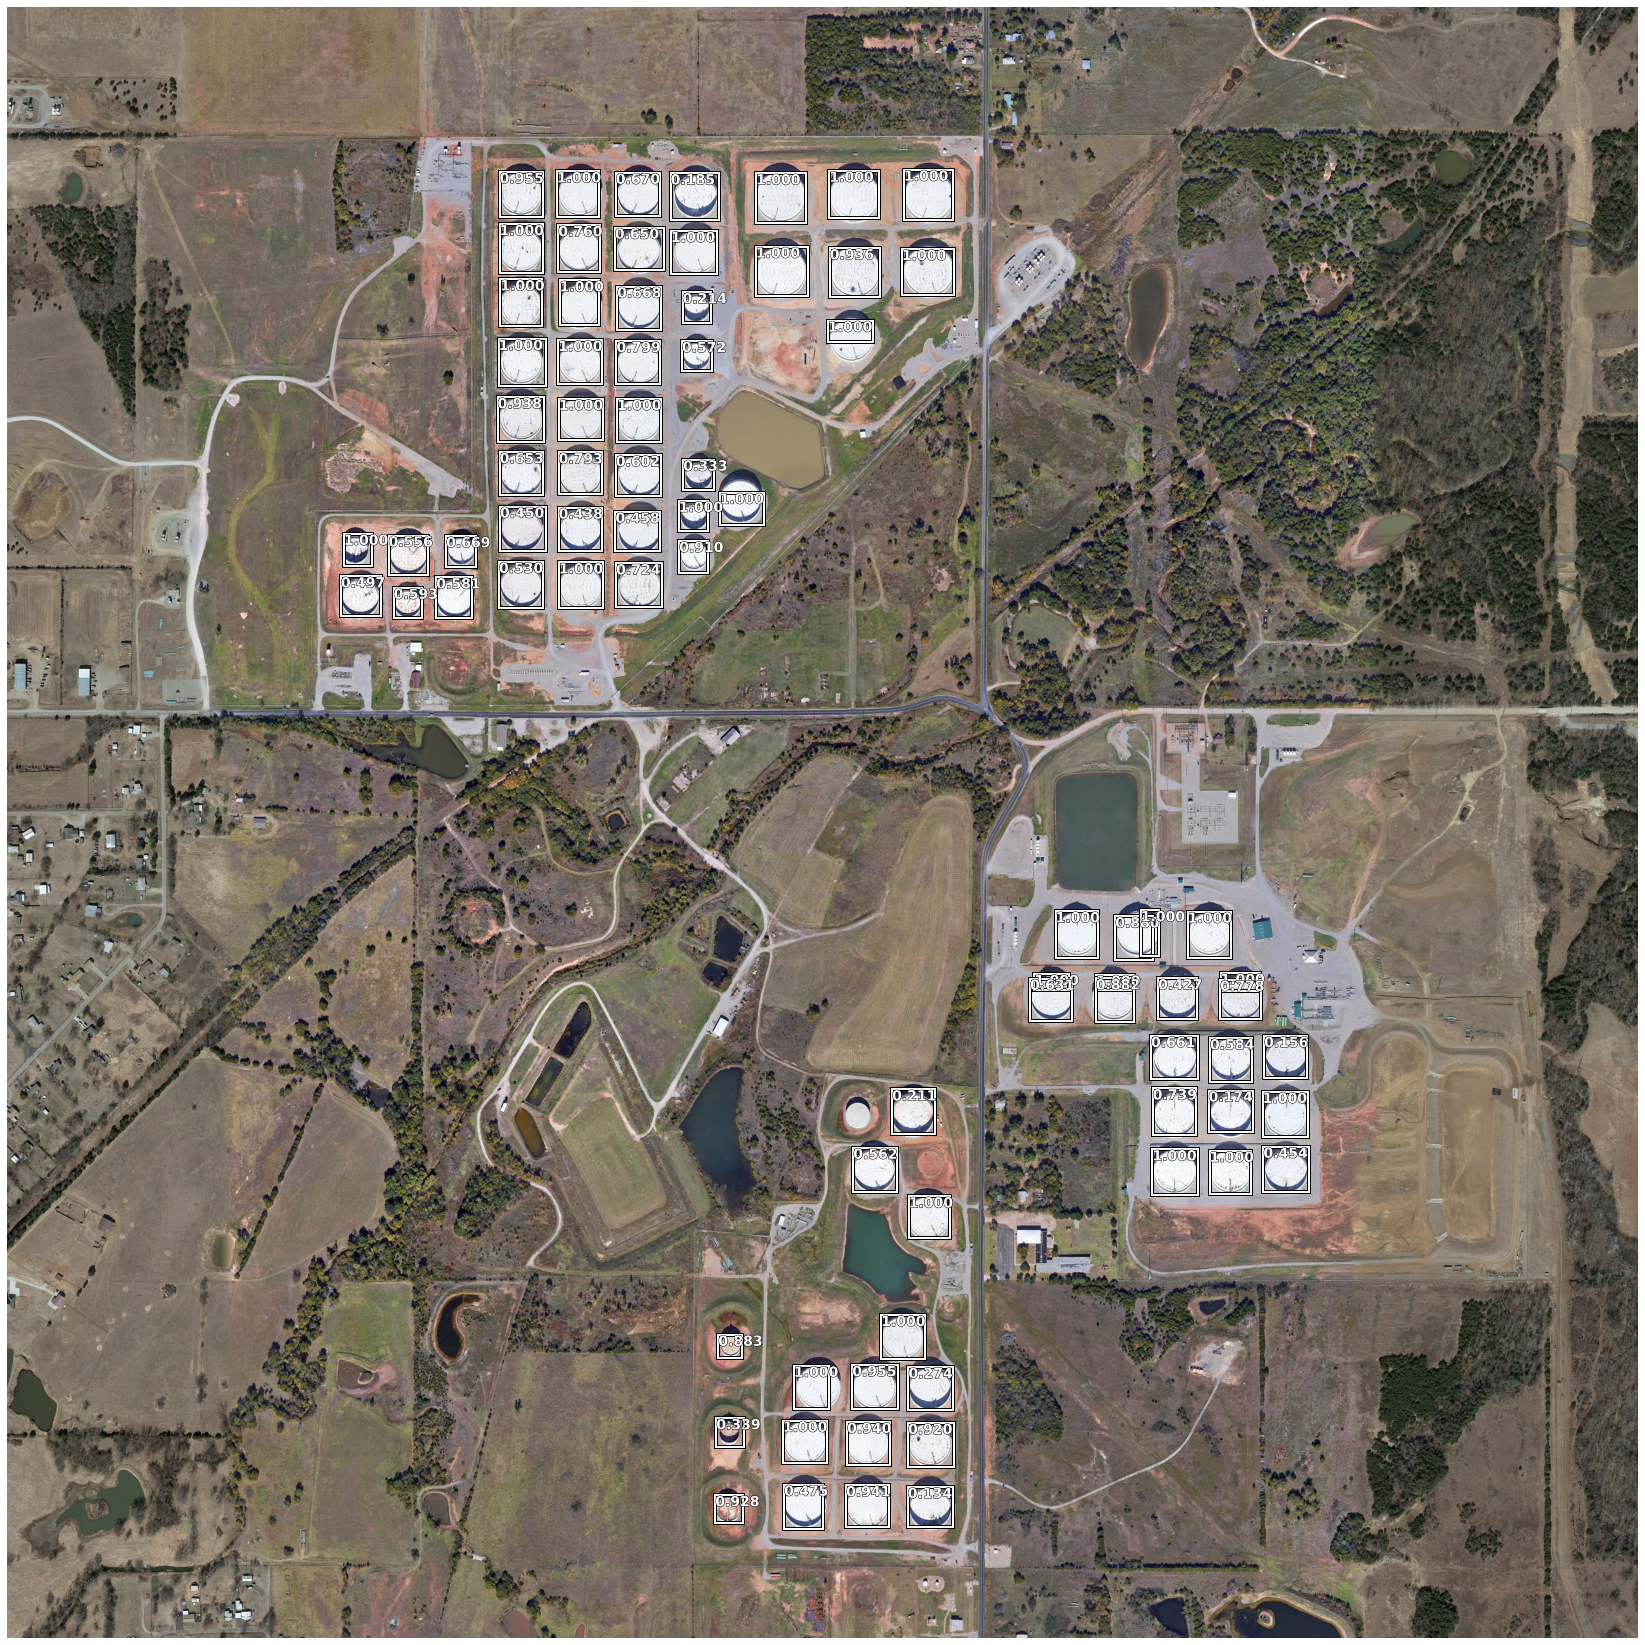

In [41]:
tank_large = MultiTank(bbs, composite_image)
tank_large.plot_volumes(figsize=(30,30))